In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.7 MB/s eta 0:00:00:00:01


## Dataset


In [4]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()

In [5]:
!unzip archive.zip

Archive:  archive.zip
  inflating: AugmentedAlzheimerDataset/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/000cdcc4-3e54-4034-a538-203c8047b564.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/0013ad52-8398-4892-9fde-060eb1ae956d.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/0015bdfc-2059-4195-8eff-9c5cf2e2c025.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/001f15e8-6ad4-4e7a-bc36-b62b984dad69.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/001f89e3-8207-4ee4-80d7-711c2acd191a.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/002cb9c1-b160-4c76-b7e4-5fb2f1b527f7.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/0033c404-4e68-438d-8312-ba5ba0100d46.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/00372fb8-22c8-4a67-8b10-564caed780fa.jpg  
  inflating: AugmentedAlzheimerDataset/MildDemented/00387cfa-b6ce-4eb0-8cc5-9273080c8187.jpg  
  inflating: AugmentedAlzhei

In [6]:
import shutil

shutil.rmtree('OriginalDataset')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "AugmentedAlzheimerDataset"

role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path="AugmentedAlzheimerDataset", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))


input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-544001512282/AugmentedAlzheimerDataset


In [4]:
# Second my HP ranges
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [5]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo_1.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p2.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs }, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................................................................................................

In [26]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-09-21 14:45:54 Starting - Preparing the instances for training
2022-09-21 14:45:54 Downloading - Downloading input data
2022-09-21 14:45:54 Training - Training image download completed. Training in progress.
2022-09-21 14:45:54 Uploading - Uploading generated training model
2022-09-21 14:45:54 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'lr': '0.0002075107667149392',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-09-21-10-14-52-313"',
 'sagemaker_program': '"hpo_1.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-211802338925/pytorch-training-2022-09-21-10-14-52-313/source/sourcedir.tar.gz"'}

In [37]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],}
print(best_hyperparameters)

{'batch_size': 128, 'lr': '0.0002075107667149392'}


## Model Profiling and Debugging
TODO: i'm Using my best hyperparameters, to create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [9]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig,CollectionConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [10]:
# TODO: Create and fit an estimator
from sagemaker.pytorch import PyTorch
best_hyperparameters={'batch_size': 128, 'lr': 0.0002075107667149392}
#best_hyperparameters=best_hyperparameters
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.p2.xlarge",
    role=role,
    framework_version="1.6",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2022-10-31 06:59:21 Starting - Starting the training job...
2022-10-31 06:59:51 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
ProfilerReport: InProgress
............
2022-10-31 07:01:52 Downloading - Downloading input data...........................
2022-10-31 07:06:26 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-31 07:06:29,211 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-31 07:06:29,246 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-31 07:06:29,257 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-31 07:06:29,960 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "

In [11]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-10-31-06-59-20-622
Region: us-east-1


In [12]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-10-31 09:45:48.431 ip-172-16-168-160.ec2.internal:25859 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-31 09:45:48.463 ip-172-16-168-160.ec2.internal:25859 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-544001512282/pytorch-training-2022-10-31-06-59-20-622/debug-output
[2022-10-31 09:45:49.089 ip-172-16-168-160.ec2.internal:25859 WARNING s3handler.py:183] Encountered the exception [SSL: KRB5_S_TKT_NYV] unexpected eof while reading (_ssl.c:2570) while reading s3://sagemaker-us-east-1-544001512282/pytorch-training-2022-10-31-06-59-20-622/debug-output/index/000000000/000000000420_worker_0.json . Will retry now


In [13]:
# TODO: Plot a debugging output.
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show();

[2022-10-31 09:46:35.263 ip-172-16-168-160.ec2.internal:25859 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-10-31 09:46:36.290 ip-172-16-168-160.ec2.internal:25859 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


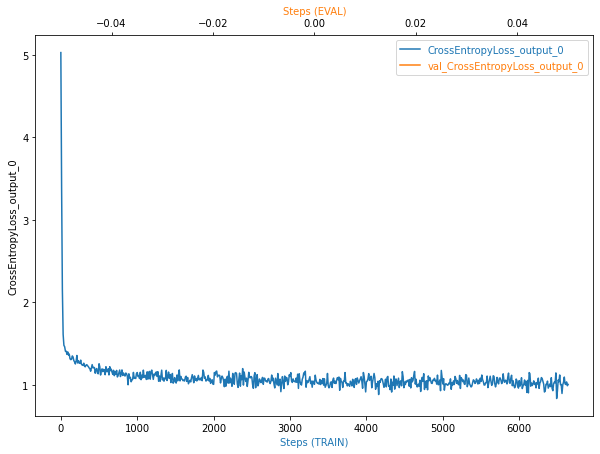

In [15]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [16]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-544001512282/pytorch-training-2022-10-31-06-59-20-622/rule-output


In [17]:
! aws s3 ls {rule_output_path} --recursive

2022-10-31 09:44:34     407132 pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-31 09:44:33     260828 pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-31 09:44:28        193 pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-31 09:44:28     251124 pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-31 09:44:28        126 pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-31 09:44:29        319 pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-31 09:44:29       5003 pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-re

In [18]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-544001512282/pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-544001512282/pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-544001512282/pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-544001512282/pytorch-training-2022-10-31-06-59-20-622/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-544001512282/pytorch-training-2022-10-31-06-59-20

In [19]:
# TODO: Display the profiler output

import os

profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [20]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [21]:
import shutil
shutil.make_archive("./model_repot_profiler", "zip", "ProfilerReport")

'/home/ec2-user/SageMaker/model_repot_profiler.zip'

In [22]:
!zip -r ProfilerReport.zip ProfilerReport

  adding: ProfilerReport/ (stored 0%)
  adding: ProfilerReport/profiler-output/ (stored 0%)
  adding: ProfilerReport/profiler-output/profiler-reports/ (stored 0%)
  adding: ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json (deflated 88%)
  adding: ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json (deflated 37%)
  adding: ProfilerReport/profiler-output/profiler-reports/StepOutlier.json (deflated 61%)
  adding: ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json (deflated 84%)
  adding: ProfilerReport/profiler-output/profiler-reports/Dataloader.json (deflated 21%)
  adding: ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json (deflated 56%)
  adding: ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json (deflated 40%)
  adding: ProfilerReport/profiler-output/profiler-reports/BatchSize.json (deflated 32%)
  adding: ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json (deflated 31